## Generate Signal and Cov Mat for MCMC.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_process import jackknife_label, load_calculation_data, calculate_jackknife_variance_global
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

In [2]:
z = 0
scale_factor = cosmos.Om(z) * cosmos.critical_density(z).to('M_sun/pc^3').value / h**2 * 1e6

## Cross Correlation

In [3]:
r_p_cross, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_6_tree.npy', return_rp=True)
dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_6_tree.npy')

In [4]:
Nside_jack = 10
quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
random_sample = np.load('../catalogue/random_quasar_lss_all.npy')

pix = jackknife_label(quasar_cata, Nside_jack)
pix_r = jackknife_label(random_sample, Nside_jack)

In [12]:
sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)

In [13]:
jack_cross = sampler_q['jackknife'] / scale_factor

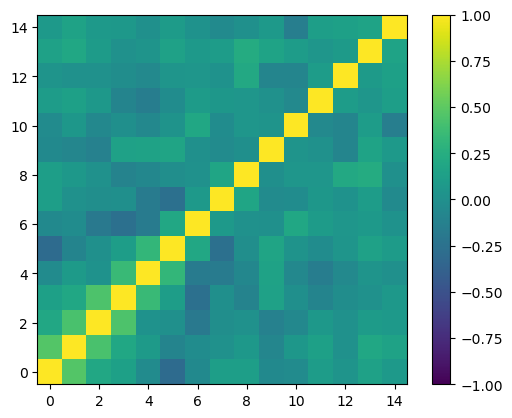

In [14]:
cov = np.cov(jack_cross, rowvar=False, ddof=0)
cov *= (jack_cross.shape[0] - 1)
std = np.sqrt([cov[i,i] for i in range(len(cov))])
cov_normed = cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

## Auto Correlation

In [2]:
from Corrfunc.mocks import DDrppi_mocks, DDtheta_mocks
from Corrfunc.io import read_catalog
from Corrfunc.theory import DDrppi, DD
from my_util import convert_rp_pi_counts_to_wp
import multiprocessing as mp
from tqdm import tqdm

In [11]:
Nbins = 15
rp_min = 3
rp_max = 100

rp_bin_cross = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_cross = (rp_bin_cross[:-1]*rp_bin_cross[1:])**0.5

sep = (np.log10(rp_max) - np.log10(rp_min)) / Nbins
rp_bin_auto = 10**(np.arange(-10, Nbins+1)*sep + np.log10(rp_min))
# rp_bin_auto = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_auto = (rp_bin_auto[:-1]*rp_bin_auto[1:])**0.5

Nbins = len(rp_bin_auto) - 1

In [13]:
Nd = len(quasar_cata)
Nr = len(random_sample)
dis_cov_q = cosmos.angular_diameter_distance(quasar_cata['z']).to(u.Mpc).value*(1+quasar_cata['z'])*h
dis_cov_r = cosmos.angular_diameter_distance(random_sample['z']).to(u.Mpc).value*(1+random_sample['z'])*h

z = 1.69
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100
d_A = cosmos.angular_diameter_distance(z).to(u.Mpc).value
chi_l = d_A*(1+z)

pimax = 100

npix = pix
npix_r =  pix_r

pix = np.unique(npix)
def resample(p, sender):
    sub_sample = npix != p
    sub_sample_r = npix_r != p

    quasar_sub = quasar_cata[sub_sample]
    random_sub = random_sample[sub_sample_r]

    dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin_auto,
                   RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin_auto,
                    RA1=random_sub['ra'], DEC1=random_sub['dec'], CZ1=dis_cov_r[sub_sample_r], weights1=random_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    dr = DDrppi_mocks(
        autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin_auto, 
        RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], 
        RA2=random_sub['ra'], DEC2=random_sub['dec'], CZ2=dis_cov_r[sub_sample_r], weights2=random_sub['w'], 
        is_comoving_dist=True, weight_type='pair_product')

    Nd = quasar_sub['w'].sum()
    Nr = random_sub['w'].sum()
    sender.send(1)
    return convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

def progress_bar(Ntotal, receiver, rate=10):
    # rate is the update rate of the progress bar.
    rate = max(1, int(rate))
    with tqdm(total=int(Ntotal/rate)) as pbar:
        count = 0
        while True:
            if receiver.recv():
                count += 1
                if count % rate == 0:
                    pbar.update(1)
            else:
                break
        pbar.close()


In [14]:
from itertools import repeat

sender, recv = mp.Pipe()

pool = mp.Pool(5)

bar = mp.Process(target=progress_bar, args=(len(pix), recv, 1))
bar.start()
jack_auto = np.vstack(list(pool.starmap(resample, zip(pix, repeat(sender)))))
sender.send(0)
bar.join()

  0%|          | 0/228 [00:00<?, ?it/s]

100%|██████████| 228/228 [19:50<00:00,  5.22s/it]


In [15]:
jackknife_all = np.concatenate((jack_cross, jack_auto), axis=1)
cov = np.cov(jackknife_all, rowvar=False, ddof=0)
cov *= (jackknife_all.shape[0] - 1)
std = np.sqrt([cov[i,i] for i in range(len(cov))])
cov_normed = cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))

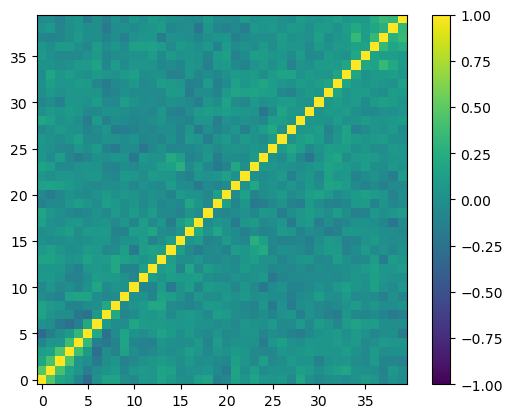

In [16]:
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

In [17]:
w_auto = jack_auto.mean(axis=0)
w_cross = jack_cross.mean(axis=0)
std_auto = std[len(w_cross):]
std_cross = std[:len(w_cross)]

In [18]:
with open('../mcmc/python/signal_sep_2/signal.npy', 'wb')  as f:
    np.save(f, r_p_auto)
    np.save(f, w_auto)
    np.save(f, r_p_cross)
    np.save(f, w_cross)
np.save('../mcmc/python/signal_sep_2/cov', cov)

In [14]:
with open('../mcmc/python/signal_sep_2/signal.npy', 'rb')  as f:
    r_p_auto = np.load(f)
    w_auto = np.load(f)
    r_p_cross = np.load(f)
    w_cross = np.load(f)
cov = np.load('../mcmc/python/signal_sep_2/cov.npy')
std = np.sqrt([cov[i,i] for i in range(len(cov))])
std_auto = std[len(w_cross):]
std_cross = std[:len(w_cross)]

In [15]:
w_auto

array([ 25.11494875,   0.79280499, -23.95995444, -21.59007914,
       -11.43257363,  64.70415733,  73.80073129,  53.76081218,
        41.41074704,  38.20093619,  34.91942537,  29.1871684 ,
        23.76701148,  19.2174472 ,  18.08313759,  12.32044246,
        10.37868643,   8.31456452,   6.17713109,   4.21186066,
         3.4362834 ,   2.24211873,   1.3950232 ,   1.15348501,
         1.10786054])

In [17]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo

In [19]:
z = 1.5
ang = 55*u.arcsec

In [22]:
cosmo.angular_diameter_distance(z)*ang.to(u.rad).value*(1+z)*0.7

<Quantity 0.83568362 Mpc>

In [16]:
r_p_auto

array([ 0.32556026,  0.41129803,  0.51961524,  0.65645828,  0.82933956,
        1.04774991,  1.32367962,  1.67227667,  2.11267834,  2.6690618 ,
        3.37197138,  4.25999539,  5.38188457,  6.79922837,  8.58983612,
       10.85200857, 13.70993443, 17.32050808, 21.88194273, 27.64465197,
       34.92499691, 44.12265385, 55.74255561, 70.4226114 , 88.96872671])

[]

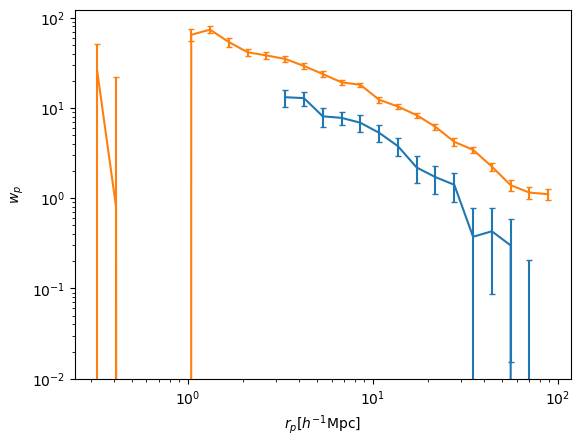

In [8]:
plt.errorbar(r_p_cross, w_cross, std_cross, capsize=2)
plt.errorbar(r_p_auto, w_auto, std_auto, capsize=2)
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel('$w_p$')
plt.loglog()

In [27]:
w_cross[-10:]

array([ 5.30653274e+00,  3.77475390e+00,  2.18818635e+00,  1.71133170e+00,
        1.40864299e+00,  3.74103621e-01,  4.30138481e-01,  3.00147914e-01,
       -6.63026922e-04, -1.91655703e-01])

In [28]:
w_auto[-10:]

array([12.32044246, 10.37868643,  8.31456452,  6.17713109,  4.21186066,
        3.4362834 ,  2.24211873,  1.3950232 ,  1.15348501,  1.10786054])

In [27]:
len(rp_bin_auto)

21